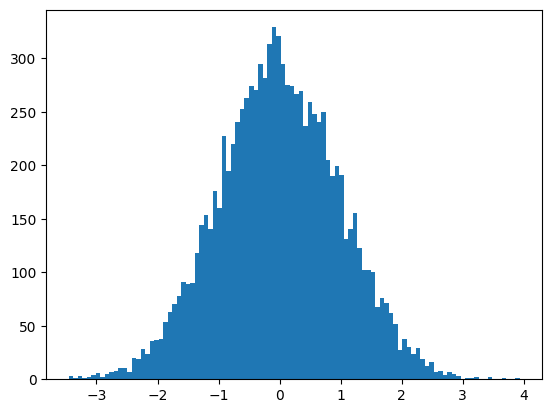

In [60]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()
size = 10000

r = rng.uniform(0, 1, size)
phi = rng.uniform(0, 1, size)

z = np.cos(2 * np.pi * phi) * np.sqrt(-2 * np.log(r))

plt.hist(z, bins=100)
plt.show()

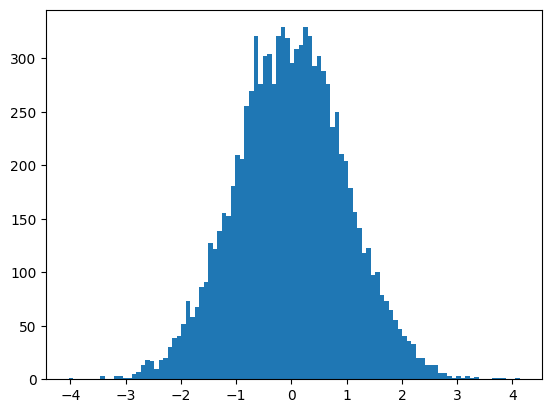

In [55]:
plt.hist(rng.normal(0, 1, size=size), bins=100)
plt.show()

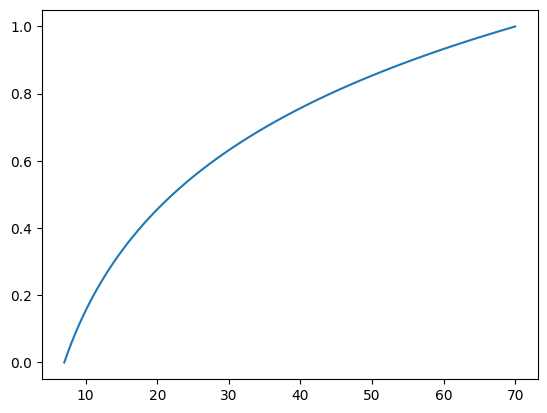

In [72]:
end = 70
start = 7
c = 1 / (np.log(end) - np.log(start))

def hyper_probs(x):
    return c * (np.log(x) - np.log(start))

size = 10000

probs = hyper_probs(np.linspace(start, end, size))
# plt.hist(probs, bins=100)
# plt.show()
plt.plot(np.linspace(start, end, size), probs)

TypeError: tuple.count() takes exactly one argument (0 given)

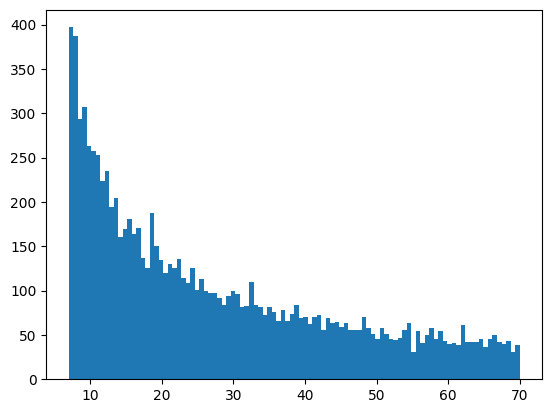

In [ ]:
def quantile(r):
    return np.exp((r / c) + np.log(start))

samples = quantile(rng.uniform(0, 1, size))

what = plt.hist(samples, bins=100)
# plt.show()


In [36]:
import time

time.perf_counter()

372404.0068621

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import Levenshtein
import librosa
import matplotlib.pyplot as plt
import MorseCodePy as mcp
from pathlib import Path
from tqdm import tqdm
import torch.nn.functional as F
import re

In [2]:
class ListDataset(torch.utils.data.Dataset):
    def __init__(self, features: list, labels: list, transform = lambda x: x):
        self.features = features
        self.labels = labels
        assert len(features) == len(labels)
        self.transform = transform
        pass

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.transform(self.features[index]), self.labels[index]

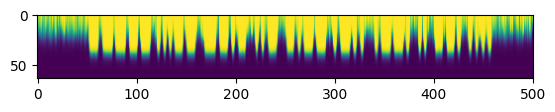

In [4]:
feature_map = torch.load(Path('data\\entropy_nfft512_nc64\\1.pt'), weights_only=True)
plt.imshow(feature_map)

In [56]:
rng = np.random.default_rng()

def rotation_transform(tensor: torch.Tensor):
    threshold = rng.integers(0, tensor.shape[0])
    result = torch.concat([tensor[threshold:], tensor[:threshold]], dim=0)
    return result

torch.Size([64, 501])


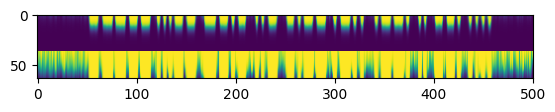

In [142]:
res = rotation_transform(feature_map)
print(res.shape)
plt.imshow(res)

In [54]:
torch.cat([torch.ones((0, 10)), torch.zeros(3, 10)], dim=0)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
import optuna


def objective(trial: optuna.Trial):
    n_epochs = 30

    n_pooled_blocks = trial.suggest_categorical('n_pooled_blocks', [2, 3, 4])
    n_head_blocks = trial.suggest_int('n_head_blocks', 0, 5)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256, 512])
    lr = trial.suggest_categorical('lr', [1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4])
    # n_blocks = 12
    inner_size = trial.suggest_categorical('inner_size', [32, 64, 128])
    # exp_gamma = 0.8
    step_gamma = trial.suggest_float('step_gamma', 0.01, 0.5)
    p_dropout = trial.suggest_float('p_dropout', 0, 0.2)

    group = 'mySomething'
    run_name = None

    config = {
        'n_epochs': n_epochs,
        'batch_size': batch_size,
        'lr': lr,
        # 'n_blocks': n_blocks,
        'n_pooled_blocks': n_pooled_blocks,
        'n_head_blocks': n_head_blocks,
        'inner_size': inner_size,
        # 'exp_gamma': exp_gamma,
        'step_gamma': step_gamma,
        'p_dropout': p_dropout,
    }

    model = MySomething(n_pooled_blocks = n_pooled_blocks, n_head_blocks = n_head_blocks,
                    input_size = 64, inner_size = inner_size, output_size = dictionary_size + 1,
                    p_dropout = p_dropout).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=exp_gamma)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=step_gamma)
    ctc_loss = nn.CTCLoss()


    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

    final_loss = 100
    with wandb.init(
            **common_wandb_kvals,
            group=group,
            config=config,
            name=run_name,
            ) as run:
        for epoch in range(n_epochs):
            model.train()
            train_loss_buffer = []
            for features, labels in tqdm(train_loader):
                features = features.to(device)
                targets, target_lengths = batch_text_transform(labels)
                targets, target_lengths = targets.to(device), target_lengths.to(torch.int32).to(device)
                outs = model(features).transpose(0, 2).transpose(1, 2)
                inputs = F.log_softmax(outs, dim=2)
                input_lengths = torch.full(size=(inputs.shape[1],), fill_value=inputs.shape[0], dtype=torch.int32).to(device)
                loss = ctc_loss(inputs, targets, input_lengths, target_lengths)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                train_loss_buffer.append(loss.detach())
            scheduler.step()
            model.eval()
            test_loss_buffer = []
            with torch.no_grad():
                for features, labels in tqdm(val_loader):
                    features = features.to(device)
                    targets, target_lengths = batch_text_transform(labels)
                    targets, target_lengths = targets.to(device), target_lengths.to(torch.int32).to(device)
                    outs = model(features).transpose(0, 2).transpose(1, 2)
                    inputs = F.log_softmax(outs, dim=2)
                    input_lengths = torch.full(size=(inputs.shape[1],), fill_value=inputs.shape[0], dtype=torch.int32).to(device)
                    loss = ctc_loss(inputs, targets, input_lengths, target_lengths)
                    test_loss_buffer.append(loss.detach())
            train_loss_value = torch.mean(torch.stack(train_loss_buffer)).item()
            test_loss_value = torch.mean(torch.stack(test_loss_buffer)).item()
            final_loss = test_loss_value
            wandb.log({
                'train_loss': train_loss_value,
                'test_loss': test_loss_value,
                'lr': scheduler.get_last_lr()[0],
            })
    return final_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

ModuleNotFoundError: No module named 'optuna'